In [2]:
import cupy as xp

In [4]:
with xp.load('2.npz',allow_pickle=True) as data:
    print(data['translations_ty'])

[ 0  0 20 20]


**Test Operators**

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import copy
import h5py
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from Operators import Split_Overlap_plan, make_probe,make_translations,cropmat
from Operators_Tile import  Tile_plan_c,map_tiles, Gplan_sub,Gplan_tile_c,Gplan_tile_c0, Alternating_projections_tiles
import Solvers
from Operators import get_times, reset_times, normalize_times
import config
from Operators import Gramiam_plan, Replicate_frame,Precondition_calc
from wrap_ops import overlap_cuda,split_cuda
import  Operators_Tile

reset_times()
GPU = config.GPU #False
sync = True
tile = True

if GPU:
    import cupy as cp
    xp = cp
    print("using GPU")
else:
    xp = np
    print("using CPU")


# input data

import sys
# Retrieve the value of 'fname' from the command-line arguments
#fname_in = sys.argv[1] if len(sys.argv) > 1 else None

fname_in = "poster_large.h5"
fid = h5py.File(fname_in, "r")

frames_data = xp.array(fid["data"], dtype=xp.float32)
illumination = xp.array(fid["probe"], dtype=xp.complex64)

translations = xp.array(fid["translations"])
#print('translations1', type(translations),translations.dtype) #float128 dtype
nframes, nx, ny = frames_data.shape

resolution = (
    xp.float32(fid["wavelength"])
    * xp.float32(fid["detector_distance"])
    / (nx * xp.float32(fid["detector_pixel_size"]))
)
translations = translations / resolution
truth = xp.array(fid["truth"], dtype=xp.complex64)

translations_x = xp.array(fid["translations_x"]) #load the real and imag of dtype int64
translations_y = xp.array(fid["translations_y"])
fid.close()

translations = (translations_x + 1j * translations_y).astype(xp.complex64)

# get the image extent (with wrap-around)
Nx = int(xp.ceil(xp.max(translations_x) - xp.min(translations_x)))
Ny = Nx
NTx = 2 #number of Tiles in x direction
NTy = NTx

#get sync plan
if sync == True:
    if GPU:
        if tile == True:
            #Get the shift of the tiles and groupid
            Tiles_plan = Tile_plan_c(NTx,NTy,translations_x, translations_y, nx, ny, Nx, Ny)
            #mapid_tiles, tiles_sizes = map_tiles(translations_x, translations_y, nx, ny, Nx, Ny,NTx,NTy,Tiles_plan) #may not need mapid_tiles
            tiles_sizes = map_tiles(translations_x, translations_y, nx, ny, Nx, Ny,NTx,NTy,Tiles_plan) #no need for v2
            
            #Get the gramiam_plan for each tile
            groupid = Tiles_plan['groupid']
            Gplan_tiles = Gplan_sub(groupid,translations_x,translations_y,nx,ny,Nx,Ny,bw = 0)
            Gplan = Gramiam_plan(translations_x,translations_y,nframes,nx,ny,Nx,Ny, bw = 0)
            #print('col is col[mask] instead')
            
         #get the Gplan to sync between tiles
            translations_tx,translations_ty=xp.meshgrid(Tiles_plan['shift_Tx'][0:-1],Tiles_plan['shift_Ty'][0:-1]) #maybe incorporate in tile_plan_c
            translations_tx = translations_tx.ravel()
            translations_ty = translations_ty.ravel()
            #treat each tile as a sub-img of different size
            Gplan_Tiles=Gplan_tile_c0(translations_tx,translations_ty,NTx * NTy,tiles_sizes[:,0].astype(int),tiles_sizes[:,1].astype(int),Nx,Ny,btw=0) 
            

            #treat each tile is an image, same as image size, 0 filled
            translations_tx = translations_tx * 0 
            translations_ty = translations_ty * 0 
            Gplan_Tiles=Gplan_tile_c(NTx * NTy,nx,ny,Nx,Ny,btw=0) 


    else:
        Gplan = Gramiam_plan(translations_x,translations_y,nframes,nx,ny,Nx,Ny, bw = 0)
        
        if Gplan['col'].size == 0:
            sync = False
else: 
    Gplan = None

    
############################
# reconstruct
refine_illumination = False
maxiter = 20
residuals_interval = 1
img_initial = xp.ones((Nx, Ny), dtype=xp.complex64) #Need to match datatype in operators fft Plan2D
#img_initial = truth +0

# threshold to check if things match within numerical accuracy
thres = np.finfo(truth.dtype).eps * 1e2



t0 = timer()
print("geometry: img size:", (Nx, Ny), "frames:", (nx, ny, nframes),"tiles:",(NTx,NTy))
print(
    "not refining illumination, starting with good one, maxiter:",
    maxiter,
)


using GPU


CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

In [2]:
#get the frames from the initial image
img_initial = truth +0
frames = xp.zeros(frames_data.shape,dtype = xp.complex64)
split_cuda(img_initial, frames, translations, illumination)
 

array([[[ 0.0719156 +5.3390293e-17j,  0.05923843+4.0113069e-03j,
          0.05576413+1.2583640e-02j, ...,  0.07565629+2.8681986e-02j,
          0.05576413+1.2583640e-02j,  0.05923843+4.0113069e-03j],
        [ 0.05837999-3.5112100e-03j,  0.03812528+3.0508737e-17j,
          0.0190022 +1.9044228e-04j, ...,  0.03802289-5.7000304e-03j,
          0.0190022 +1.9044228e-04j,  0.03812528+2.7648543e-17j],
        [ 0.05070539-8.6602513e-03j,  0.01816121+2.2879369e-04j,
         -0.030778  -2.3206077e-04j, ..., -0.02134579-4.0785417e-02j,
         -0.03124652-2.2881554e-17j,  0.0190022 -1.9044228e-04j],
        ...,
        [ 0.07702313-2.8537856e-02j,  0.03802289+5.7000304e-03j,
         -0.02198167+4.1240536e-02j, ..., -0.02539644+1.7161165e-17j,
         -0.02198167+4.1240536e-02j,  0.03446275+6.7723817e-03j],
        [ 0.05576413-1.2583640e-02j,  0.0190022 -1.9044228e-04j,
         -0.03124652-2.2881554e-17j, ..., -0.02198167-4.1240536e-02j,
         -0.03124652-2.2881554e-17j,  0.0187187 

In [3]:
#randomize frame-wise phases
phases=xp.exp(1j*xp.random.random((nframes,1,1),dtype = xp.float32)*2*xp.pi)
frames_rand=frames * phases
#frames_rand = frames*0 + 1

[[ 0.06631751-0.29468074j  0.16650432-0.11594497j  0.44531098+0.02322438j
  ...  0.16773464-0.29108754j  0.10860204-0.32553214j
   0.2016364 -0.3669063j ]
 [ 0.3194979 -0.46575922j  0.46902278-0.33678076j  0.62196976-0.20492768j
  ... -0.03299005-0.37668768j  0.12245448-0.4507289j
   0.29517722-0.5010698j ]
 [ 0.4717628 -0.49827045j  0.5180389 -0.4296683j   0.5357906 -0.35855973j
  ... -0.05710215-0.4589431j   0.11047221-0.5408504j
   0.38254687-0.5527564j ]
 ...
 [ 0.4339083 -0.08864225j  0.4422147 -0.04326661j  0.37831157-0.07768366j
  ...  0.12965403-0.11508819j  0.3294847 -0.08938597j
   0.4951724 -0.099305j  ]
 [ 0.1780672 -0.02008864j  0.18972743+0.04092227j  0.2420965 +0.05810681j
  ...  0.28877896-0.09927968j  0.2457114 -0.09507219j
   0.34356612-0.09610264j]
 [ 0.04770092-0.07018746j  0.03975108+0.06498539j  0.29639772+0.12972336j
  ...  0.28694525-0.1511496j   0.1815624 -0.18749504j
   0.23695533-0.20283385j]]
[[1.        +2.35508280e-17j 1.0000001 -6.11951867e-09j
  1.      

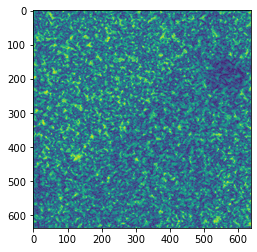

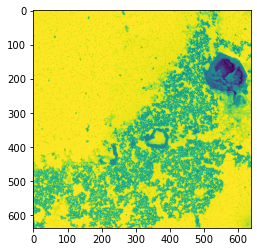

1.3102775e-07


In [4]:
#overlap to get-back original image
normalization = xp.zeros(truth.shape,dtype = xp.complex64)
overlap_cuda(normalization, 0, translations, illumination) 

#with random phase
img0 = xp.zeros(truth.shape,dtype = xp.complex64)
overlap_cuda(img0, frames_rand, translations, illumination) 
img0 = img0 /(normalization +1e-32)
print(img0)

#wo random phase
img00 = xp.zeros(truth.shape,dtype = xp.complex64)
overlap_cuda(img00, frames, translations, illumination) 
img00 = img00 /(normalization +1e-32)
print(img00)

plt.imshow(abs(img0.get()))
plt.show()
plt.imshow(abs(img00.get()))
plt.show()
print(xp.linalg.norm(img00-truth)/xp.linalg.norm(truth))

  (0, 0)	(0.1330649+0j)
  (0, 1)	(0.05345349+0.0067424434j)
  (0, 2)	(0.015196012-0.011092928j)
  (0, 3)	(0.0034843613+0.0015976283j)
  (0, 4)	(-0.00022507264-0.000327764j)
  (0, 5)	(3.654212e-05-1.270879e-05j)
  (0, 6)	(-9.737546e-06-2.0706914e-06j)
  (0, 122)	(-4.785815e-06+1.8103023e-05j)
  (0, 123)	(-3.601768e-06+0.00016706431j)
  (0, 124)	(-0.0002652677-0.0018500733j)
  (0, 125)	(0.006509919+0.0036988102j)
  (0, 126)	(-0.02486079-0.026906544j)
  (0, 127)	(0.04845897+0.08101918j)
  (0, 128)	(-0.025208553-0.048802808j)
  (0, 129)	(-0.0456677-0.034810692j)
  (0, 130)	(-0.002370576+0.010399545j)
  (0, 131)	(0.00016715185+0.002943588j)
  (0, 132)	(0.0005448111-0.00062229246j)
  (0, 133)	(-6.164765e-05-6.666401e-05j)
  (0, 134)	(1.7923367e-05+3.8299254e-06j)
  (0, 250)	(-7.498162e-06+4.010038e-06j)
  (0, 251)	(6.0389077e-05+2.4972333e-05j)
  (0, 252)	(-0.00038810069+0.0006900035j)
  (0, 253)	(0.00096305885+0.0022347495j)
  (0, 254)	(-0.0053828266-0.0039576404j)
  :	:
  (16383, 16129)	(8

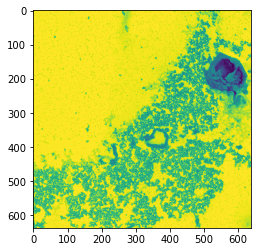

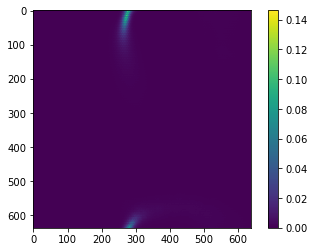

0.0039458126


In [5]:
from Operators import synchronize_frames_c
frames_norm = Precondition_calc(frames_rand, bw=Gplan['bw'])
img = truth + 0 

#synchronization 
reg = 1e-32
normalization = xp.zeros(truth.shape,dtype = xp.complex64)
overlap_cuda(normalization, 0, translations, illumination) 
inormalization_split = xp.zeros(frames_data.shape,dtype = xp.complex64)
split_cuda(1/(normalization+reg),inormalization_split,translations, 0)

omega=synchronize_frames_c(frames_rand, illumination, frames_norm, inormalization_split, Gplan, Gplan['bw'],1000)
frames = frames_rand * omega
img *= 0 
overlap_cuda(img, frames,translations, illumination) 
img = img/normalization

plt.imshow(abs(img.get()))
plt.show()

plt.imshow(xp.abs(truth).get()-xp.abs(img).get())
plt.colorbar()
plt.show()

print(xp.linalg.norm(abs(truth)-abs(img))/xp.linalg.norm(truth))

In [7]:
#normalization for within each tile
reg = 1e-32
normalization_tiles = xp.zeros((NTx * NTy,truth.shape[0],truth.shape[1]),dtype = xp.complex64)
inormalization_split_tiles = [None] * (NTx * NTy) 
for j in range(NTx * NTy):
    normalization_tilesi = xp.zeros(truth.shape,dtype = xp.complex64)
    translationsj = translations[groupid == j] + 0 
    overlap_cuda(normalization_tilesi, 0, translationsj , illumination)         
        
    normalization_tiles[j,:,:] = normalization_tilesi + 0 #checked! difference is that this is of the size img.
    
    nframesintile = xp.sum(groupid == j)

    inormalization_split_tilesi = xp.zeros((int(nframesintile),frames_data.shape[1],frames_data.shape[2]),dtype = xp.complex64) 
            
    split_cuda(1/(normalization_tilesi+reg),inormalization_split_tilesi,translationsj , 0)
            
    inormalization_split_tiles[j] = inormalization_split_tilesi + 0#checked

  (0, 0)	(0.45996964+0j)
  (0, 1)	(0.13317539+0.016798295j)
  (0, 2)	(0.032434795-0.02367706j)
  (0, 3)	(0.0093714+0.004296918j)
  (0, 4)	(-0.00077097095-0.0011227331j)
  (0, 5)	(0.00028714017-9.986295e-05j)
  (0, 6)	(-8.76139e-05-1.8631115e-05j)
  (0, 64)	(-0.0655184-0.12684116j)
  (0, 65)	(-0.083210304-0.06342794j)
  (0, 66)	(-0.0043607634+0.019130351j)
  (0, 67)	(0.00037493845+0.006602764j)
  (0, 68)	(0.0011988225-0.0013693154j)
  (0, 69)	(-0.00015149025-0.00016381725j)
  (0, 70)	(6.1280574e-05+1.3094644e-05j)
  (0, 128)	(-0.030704435-0.01726359j)
  (0, 129)	(-0.011159828+0.0041604266j)
  (0, 130)	(-0.0033499287-0.0039811917j)
  (0, 131)	(0.00038805432-0.0022931686j)
  (0, 132)	(-0.00042224285+0.00022330949j)
  (0, 133)	(4.6790152e-05-7.12647e-06j)
  (0, 134)	(8.37061e-06+5.066357e-06j)
  (0, 192)	(0.007425372+0.0036817451j)
  (0, 193)	(-0.003514901-0.0039200825j)
  (0, 194)	(0.000614264+0.002964579j)
  (0, 195)	(4.8782306e-07-0.0014763982j)
  :	:
  (4095, 3900)	(-0.0005987926-0.001

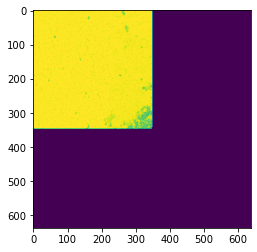

  (0, 0)	(0.45894545+0j)
  (0, 1)	(-0.04887358-0.12566666j)
  (0, 2)	(0.02131989-0.034296464j)
  (0, 3)	(-0.009506024-0.0040121805j)
  (0, 4)	(-0.0010424699-0.00088075857j)
  (0, 5)	(-5.338488e-05-0.00030639677j)
  (0, 6)	(6.160859e-05+6.502412e-05j)
  (0, 64)	(0.05767583+0.13139333j)
  (0, 65)	(0.04944126+0.09367651j)
  (0, 66)	(-0.019678703+0.0011641661j)
  (0, 67)	(-0.0034233404+0.0057089007j)
  (0, 68)	(-0.00067330344+0.0017027721j)
  (0, 69)	(-0.00022628509-1.9765046e-05j)
  (0, 70)	(-4.1431736e-05+4.6863075e-05j)
  (0, 128)	(0.013520832-0.032840032j)
  (0, 129)	(-0.011856086-0.0013197105j)
  (0, 130)	(-0.004854629+0.0018780947j)
  (0, 131)	(-0.00095629797+0.0021242313j)
  (0, 132)	(-0.0004690193-8.826197e-05j)
  (0, 133)	(2.384227e-05+4.0713076e-05j)
  (0, 134)	(-8.891948e-06+4.1054136e-06j)
  (0, 192)	(-0.0032558022-0.007610021j)
  (0, 193)	(-0.002610418-0.0045589334j)
  (0, 194)	(-0.0013802077-0.0026781969j)
  (0, 195)	(-0.00097453396-0.0011093873j)
  :	:
  (4095, 3900)	(-7.674

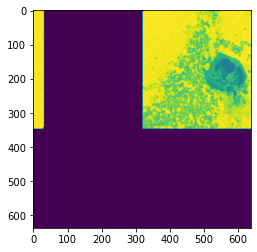

  (0, 0)	(0.454718+0j)
  (0, 1)	(0.099728756+0.09042307j)
  (0, 2)	(-0.010875214-0.03917183j)
  (0, 3)	(0.0052332063-0.008798862j)
  (0, 4)	(0.0007512267-0.0011410093j)
  (0, 5)	(0.0003070516-5.935502e-05j)
  (0, 6)	(-4.678648e-05-7.769311e-05j)
  (0, 64)	(0.03852051+0.13599126j)
  (0, 65)	(-0.104239635+0.02034463j)
  (0, 66)	(-0.00025171245+0.019991808j)
  (0, 67)	(-0.006376914-0.0014458799j)
  (0, 68)	(0.0015265227+0.0010184218j)
  (0, 69)	(-0.00020618342+9.4715964e-05j)
  (0, 70)	(5.619357e-05-2.7487275e-05j)
  (0, 128)	(0.032053612+0.015421929j)
  (0, 129)	(-0.007605168-0.009442752j)
  (0, 130)	(-0.0022503203-0.0047692917j)
  (0, 131)	(-0.0020092912+0.0011188046j)
  (0, 132)	(0.00045486027+0.00015825358j)
  (0, 133)	(-2.6897307e-05-3.8933016e-05j)
  (0, 134)	(9.891504e-06-7.610607e-07j)
  (0, 192)	(-0.008165375-0.0014473009j)
  (0, 193)	(0.004245185+0.0030293902j)
  (0, 194)	(-0.0027313682+0.0012723764j)
  (0, 195)	(0.00088821916-0.0011561516j)
  :	:
  (4095, 3900)	(0.0011515612-0.

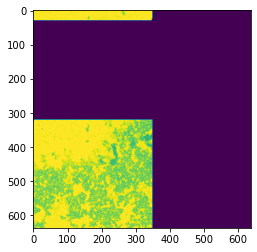

  (0, 0)	(0.443588+0j)
  (0, 1)	(-0.015632536-0.13270283j)
  (0, 2)	(-0.039798874+0.006385941j)
  (0, 3)	(0.0095330225-0.0045158598j)
  (0, 4)	(0.00075454434-0.0012695411j)
  (0, 5)	(0.0002295846-0.00028117042j)
  (0, 6)	(8.271958e-05+8.6363936e-05j)
  (0, 64)	(-0.14593017-0.0055678403j)
  (0, 65)	(0.10134932+0.06252487j)
  (0, 66)	(0.018956274+0.004628146j)
  (0, 67)	(0.0054419674+0.0031205192j)
  (0, 68)	(0.0002367198-0.0016329113j)
  (0, 69)	(0.00013958206-0.00014799868j)
  (0, 70)	(4.4110907e-06+6.914394e-05j)
  (0, 128)	(0.014888944+0.036363643j)
  (0, 129)	(0.009855639+0.005749069j)
  (0, 130)	(0.004472922+0.0021691117j)
  (0, 131)	(-0.0021620118-0.0012042801j)
  (0, 132)	(0.000265963-0.0003991405j)
  (0, 133)	(2.6020016e-05-3.9440474e-05j)
  (0, 134)	(9.858234e-06+2.849443e-06j)
  (0, 192)	(-0.007645482-0.0023273656j)
  (0, 193)	(0.0044848137+0.00078572734j)
  (0, 194)	(-0.002177725+0.0016119999j)
  (0, 195)	(0.00034687255-0.0014767908j)
  :	:
  (4095, 3900)	(0.00051514525+0.001

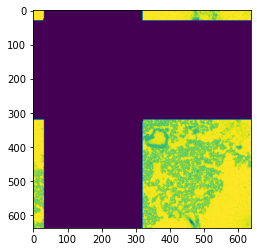

In [8]:
Tile = xp.zeros((NTx*NTy,truth.shape[0],truth.shape[1]),dtype = xp.complex64)
frames = xp.zeros((nframes,nx,ny),dtype=xp.complex64)
split_cuda(truth,frames,translations,illumination)
frames = frames * phases

from Operators import synchronize_frames_c
frames_norm = Precondition_calc(frames, bw=Gplan_tiles[0]['bw']) #check!
for j in range(NTx * NTy):
    
    framesi = frames[groupid == j] + 0 
    translationsj = translations[groupid == j] + 0 
    frames_normj = frames_norm[groupid == j] + 0 
    omega=synchronize_frames_c(framesi, illumination +0, frames_normj, inormalization_split_tiles[j]+0, Gplan_tiles[j], Gplan_tiles[j]['bw'],500)
    #checked H and omega OK
    
    framesi = framesi * omega
    
    imagei = xp.zeros(truth.shape,dtype = xp.complex64)
    overlap_cuda(imagei, framesi,translationsj , illumination)
    Tile[j,:,:] = imagei / (normalization_tiles[j,:,:]+reg) #normalize here or later?
    #Here each Tile[j,:,:] is of image shape

    plt.imshow(abs(Tile[j,:,:].get()))
    plt.show()

[[3.+0.j 3.+0.j 4.+0.j ... 2.+0.j 2.+0.j 2.+0.j]
 [3.+0.j 3.+0.j 4.+0.j ... 2.+0.j 2.+0.j 2.+0.j]
 [3.+0.j 3.+0.j 4.+0.j ... 2.+0.j 2.+0.j 2.+0.j]
 ...
 [2.+0.j 2.+0.j 2.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [2.+0.j 2.+0.j 2.+0.j ... 1.+0.j 1.+0.j 1.+0.j]
 [2.+0.j 2.+0.j 2.+0.j ... 1.+0.j 1.+0.j 1.+0.j]]


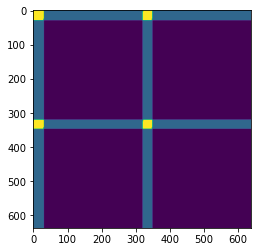

In [9]:
#checked to be right
#normalization for between tiles
illumination_one = abs(xp.sign(normalization_tiles)).astype(xp.complex64) #get an all one Tiles
normalization_overall = xp.sum(illumination_one,axis=0) 
normalization_overall.astype(xp.complex64) 

plt.imshow(abs(normalization_overall.get()))
print(normalization_overall)

  (0, 0)	(0.8413238+0j)
  (0, 1)	(0.050332285+0.028471021j)
  (0, 2)	(-0.07449336+0.00055893924j)
  (0, 3)	(0.0017488477+0.003833817j)
  (1, 0)	(0.050332285-0.028471021j)
  (1, 1)	(0.81512654+0j)
  (1, 2)	(-0.0038874312+0.0011619348j)
  (1, 3)	(0.0009200035+0.045872346j)
  (2, 0)	(-0.07449336-0.00055893924j)
  (2, 1)	(-0.0038874312-0.0011619348j)
  (2, 2)	(0.83115923+0j)
  (2, 3)	(-0.049531296-0.010824091j)
  (3, 0)	(0.0017488477-0.003833817j)
  (3, 1)	(0.0009200035-0.045872346j)
  (3, 2)	(-0.049531296+0.010824091j)
  (3, 3)	(0.83737+0j)
[-0.62677795+0.j         -0.36718506+0.06348846j  0.5644677 -0.09884211j
 -0.24029508+0.28663296j]
testing for nan False
[ 0.9066937 +0.4217895j   0.9653004 +0.26114187j -0.96585613-0.25907922j
  0.90573144-0.4238521j ]
{'col': array([0, 0, 0, 0, 1, 1, 1, 2, 2, 3]), 'row': array([0, 1, 2, 3, 1, 2, 3, 2, 3, 3]), 'dtx': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'dty': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'val': array([[0.+0.j],
       [0.+0.j],
       [0.

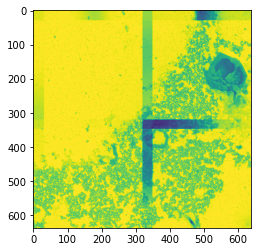

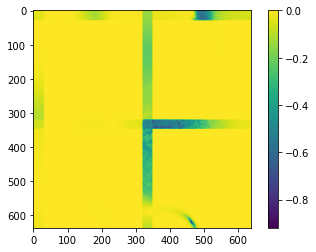

0.08751719


In [10]:
#get back the original image
translations_t = (translations_tx + 1j * translations_ty).astype(xp.complex64)
inormalization_split_overall = xp.zeros((NTx * NTy,truth.shape[0],truth.shape[1]),dtype = xp.complex64) #all ones?
split_cuda(1/(normalization_overall + reg),inormalization_split_overall,translations_t * 0  , 0)

Tiles_norm = Precondition_calc(Tile, Gplan_tiles[0]['bw'])
omega_tiles=synchronize_frames_c(Tile , 0, Tiles_norm, inormalization_split_overall, Gplan_Tiles,100) 
print(Gplan_Tiles)
print(omega_tiles)
#omega_tiles is wrong!!!

#omega_tiles = 1
img = xp.sum(Tile * omega_tiles,axis=0)
img = img / normalization_overall
#img = img
plt.imshow(abs(img.get()))
plt.show()
plt.imshow((xp.abs(img)-xp.abs(truth)).get())
plt.colorbar()
plt.show()

print(xp.linalg.norm(abs(img)-abs(truth))/xp.linalg.norm(truth))

**Operators is working!!!**

**problem is with proxD single precision?**

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import copy
import h5py
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from Operators import Split_Overlap_plan, make_probe,make_translations,cropmat
from Operators_Tile import  Tile_plan_c,map_tiles, Gplan_sub,Gplan_tile_c,Gplan_tile_c0, Alternating_projections_tiles
import Solvers
from Operators import get_times, reset_times, normalize_times
import config
from Operators import Gramiam_plan, Replicate_frame,Precondition_calc
from wrap_ops import overlap_cuda,split_cuda
import  Operators_Tile

reset_times()
GPU = config.GPU #False
sync = True
tile = True

if GPU:
    import cupy as cp
    xp = cp
    print("using GPU")
else:
    xp = np
    print("using CPU")


# input data

import sys
# Retrieve the value of 'fname' from the command-line arguments
#fname_in = sys.argv[1] if len(sys.argv) > 1 else None

fname_in = "poster_large.h5"
fid = h5py.File(fname_in, "r")

frames_data = xp.array(fid["data"], dtype=xp.float32)
illumination = xp.array(fid["probe"], dtype=xp.complex64)

translations = xp.array(fid["translations"])
#print('translations1', type(translations),translations.dtype) #float128 dtype
nframes, nx, ny = frames_data.shape

resolution = (
    xp.float32(fid["wavelength"])
    * xp.float32(fid["detector_distance"])
    / (nx * xp.float32(fid["detector_pixel_size"]))
)
translations = translations / resolution
truth = xp.array(fid["truth"], dtype=xp.complex64)

translations_x = xp.array(fid["translations_x"]) #load the real and imag of dtype int64
translations_y = xp.array(fid["translations_y"])
fid.close()

translations = (translations_x + 1j * translations_y).astype(xp.complex64)

# get the image extent (with wrap-around)
Nx = int(xp.ceil(xp.max(translations_x) - xp.min(translations_x)))
Ny = Nx
NTx = 2 #number of Tiles in x direction
NTy = NTx

#get sync plan
if sync == True:
    if GPU:
        if tile == True:
            #Get the shift of the tiles and groupid
            Tiles_plan = Tile_plan_c(NTx,NTy,translations_x, translations_y, nx, ny, Nx, Ny)
            #mapid_tiles, tiles_sizes = map_tiles(translations_x, translations_y, nx, ny, Nx, Ny,NTx,NTy,Tiles_plan) #may not need mapid_tiles
            tiles_sizes = map_tiles(translations_x, translations_y, nx, ny, Nx, Ny,NTx,NTy,Tiles_plan) #no need for v2
            
            #Get the gramiam_plan for each tile
            groupid = Tiles_plan['groupid']
            Gplan_tiles = Gplan_sub(groupid,translations_x,translations_y,nx,ny,Nx,Ny,bw = 0)
            Gplan = Gramiam_plan(translations_x,translations_y,nframes,nx,ny,Nx,Ny, bw = 0)
            #print('col is col[mask] instead')
            
         #get the Gplan to sync between tiles
            translations_tx,translations_ty=xp.meshgrid(Tiles_plan['shift_Tx'][0:-1],Tiles_plan['shift_Ty'][0:-1]) #maybe incorporate in tile_plan_c
            translations_tx = translations_tx.ravel()
            translations_ty = translations_ty.ravel()
            #treat each tile as a sub-img of different size
            Gplan_Tiles=Gplan_tile_c0(translations_tx,translations_ty,NTx * NTy,tiles_sizes[:,0].astype(int),tiles_sizes[:,1].astype(int),Nx,Ny,btw=0) 
            

            #treat each tile is an image, same as image size, 0 filled
            translations_tx = translations_tx * 0 
            translations_ty = translations_ty * 0 
            Gplan_Tiles=Gplan_tile_c(NTx * NTy,nx,ny,Nx,Ny,btw=0) 


    else:
        Gplan = Gramiam_plan(translations_x,translations_y,nframes,nx,ny,Nx,Ny, bw = 0)
        
        if Gplan['col'].size == 0:
            sync = False
else: 
    Gplan = None

    
############################
# reconstruct
refine_illumination = False
maxiter = 20
residuals_interval = 1
img_initial = xp.ones((Nx, Ny), dtype=xp.complex64) #Need to match datatype in operators fft Plan2D
#img_initial = truth +0

# threshold to check if things match within numerical accuracy
thres = np.finfo(truth.dtype).eps * 1e2



t0 = timer()
print("geometry: img size:", (Nx, Ny), "frames:", (nx, ny, nframes),"tiles:",(NTx,NTy))
print(
    "not refining illumination, starting with good one, maxiter:",
    maxiter,
)

using GPU
NXI int64
NXI int64
NXI int64
NXI int64
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3] [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]
geometry: img size: (637, 637) frames: (32, 32, 16384) tiles: (2, 2)
not refining illumination, starting with good one, maxiter: 20


In [3]:
#normalization for within each tile
reg = 1e-16
normalization_tiles = xp.zeros((NTx * NTy,truth.shape[0],truth.shape[1]),dtype = xp.complex64)
inormalization_split_tiles = [None] * (NTx * NTy) 
for j in range(NTx * NTy):
    normalization_tilesi = xp.zeros(truth.shape,dtype = xp.complex64)
    translationsj = translations[groupid == j] + 0 
    overlap_cuda(normalization_tilesi, 0, translationsj , illumination)         
        
    normalization_tiles[j,:,:] = normalization_tilesi + 0 #checked! difference is that this is of the size img.
    
    nframesintile = xp.sum(groupid == j)

    inormalization_split_tilesi = xp.zeros((int(nframesintile),frames_data.shape[1],frames_data.shape[2]),dtype = xp.complex64) 
            
    split_cuda(1/(normalization_tilesi+reg),inormalization_split_tilesi,translationsj , 0)
            
    inormalization_split_tiles[j] = inormalization_split_tilesi + 0#checked

In [4]:
normalization = xp.zeros(truth.shape,dtype = xp.complex64)
overlap_cuda(normalization, 0, translations, illumination) 

inormalization_split = xp.zeros((NTx*NTy,truth.shape[0],truth.shape[1]),dtype = xp.complex64)
for i in range(NTx * NTy):
    inormalization_split[i] = xp.copy(1/(normalization+reg))

In [5]:
from tqdm import tqdm
from Operators import Project_data,mse_calc,synchronize_frames_c

img_truth = xp.array(truth)
Tile = xp.zeros((NTx*NTy,img_truth.shape[0],img_truth.shape[1]),dtype = xp.complex64)
maxiter = 100
num_iter = 30

compute_residuals = True
nresiduals = int(np.ceil(maxiter / residuals_interval))
residuals = xp.zeros((nresiduals, 4), dtype=xp.float32)
frames_norm_sum = xp.linalg.norm(xp.sqrt(frames_data))
#dtype xp.float32

# renormalize the norm for the ifft2 space
frames_norm_r = frames_norm_sum / xp.sqrt(xp.prod(xp.array(frames_data.shape[-2:])))
nrm_truth = xp.linalg.norm(img_truth)

####starting point
img_initial = xp.ones((Nx, Ny), dtype=xp.complex64)
#img_initial = truth + 0
frames = xp.zeros(frames_data.shape,dtype = xp.complex64)
#frames = frames_rand + 0 #working 
split_cuda(img_initial, frames, translations, illumination)
frames_norm = Precondition_calc(frames, 0)


for ii in tqdm(range(maxiter)):
    
    frames, mse_data = Project_data(frames, frames_data , compute_residuals=compute_residuals)
    
    if compute_residuals:
        residuals[ii // residuals_interval, 1] = mse_data
        
    frames_old = frames + 0.0  # make a copy
 
    
    ####################
    # here goes the synchronization within tiles
    if sync==True:
        
        for j in range(NTx * NTy):
            
            framesi = frames[groupid == j] + 0 
            translationsj = translations[groupid == j] + 0 
            frames_normj = frames_norm[groupid == j] + 0 

            omega=synchronize_frames_c(framesi+0, illumination+0, frames_normj+0, inormalization_split_tiles[j]+0, Gplan_tiles[j], Gplan_tiles[j]['bw'],1)
         
            
            framesi = framesi * omega
            
            imagei = xp.zeros(img_truth.shape,dtype = xp.complex64)
            overlap_cuda(imagei, framesi,translationsj , illumination )
            
            #plt.imshow(abs(imagei.get()))
            #plt.show()
            
            #Tile[j,:,:] = imagei / (normalization_tiles[j,:,:] + 1e-8)#normalize here or later?
            Tile[j,:,:] = imagei 
    
        ##################
        #here goes synchronization between tiles
        Tiles_norm = Precondition_calc(Tile, Gplan_tiles[0]['bw'])
       
        if GPU:
            if NTx* NTy == 1:
                omega_tiles = 1
            else:
                omega_tiles=synchronize_frames_c(Tile , 0, Tiles_norm, inormalization_split, Gplan_Tiles,100) 
                #omega_tiles = 1
                
        else:
            omega_tiles=synchronize_frames_c(padded_Tile, 1 + 0j, Tiles_norm, inormalization_split_overall, Gplan_Tiles,num_iter)
              
  

        img = xp.sum(Tile * omega_tiles,axis=0)
        #img = img / (normalization_overall + 1e-16)
        #img = img / (normalization_overall + 1e-8)
        img = img / (normalization + 1e-8)
        
        frames = xp.zeros(frames_data.shape,dtype = xp.complex64)
        split_cuda(img,frames, translations,illumination)
        

        if compute_residuals:
            residuals[ii // residuals_interval, 2] = xp.linalg.norm(frames - frames_old)
                # residuals[ii//residuals_interval,2] = xp.inner((frames-frames_old).ravel(),(frames-frames_old).ravel())
            
       
        if type(img_truth) != type(None):
            if compute_residuals:
                nmse0 = mse_calc(img_truth, img)
                residuals[ii // residuals_interval, 0] = nmse0
   
   

residuals[:, 1] /= frames_norm_sum
residuals[:, 2] /= frames_norm_r
if type(img_truth) != type(None):
    residuals[:, 0] /= nrm_truth
    residuals[:,3] = 1/residuals[:,0] #|truth|/|img-truth| measures the SNR




  1%|          | 1/100 [00:00<01:03,  1.56it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


  7%|▋         | 7/100 [00:00<00:09, 10.08it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 10%|█         | 10/100 [00:01<00:06, 13.05it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 16%|█▌        | 16/100 [00:01<00:04, 16.99it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 19%|█▉        | 19/100 [00:01<00:04, 18.21it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 25%|██▌       | 25/100 [00:01<00:03, 19.72it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 28%|██▊       | 28/100 [00:01<00:03, 20.17it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 31%|███       | 31/100 [00:02<00:03, 20.48it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 37%|███▋      | 37/100 [00:02<00:03, 20.86it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 40%|████      | 40/100 [00:02<00:02, 20.98it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 46%|████▌     | 46/100 [00:02<00:02, 21.09it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 49%|████▉     | 49/100 [00:02<00:02, 21.13it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 55%|█████▌    | 55/100 [00:03<00:02, 21.19it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 58%|█████▊    | 58/100 [00:03<00:01, 21.18it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 64%|██████▍   | 64/100 [00:03<00:01, 21.20it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 67%|██████▋   | 67/100 [00:03<00:01, 21.20it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 70%|███████   | 70/100 [00:03<00:01, 21.21it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 76%|███████▌  | 76/100 [00:04<00:01, 21.12it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 79%|███████▉  | 79/100 [00:04<00:00, 21.17it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 85%|████████▌ | 85/100 [00:04<00:00, 21.22it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 88%|████████▊ | 88/100 [00:04<00:00, 21.23it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


 94%|█████████▍| 94/100 [00:05<00:00, 21.24it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H 

 97%|█████████▋| 97/100 [00:05<00:00, 21.25it/s]

False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


100%|██████████| 100/100 [00:05<00:00, 18.84it/s]

testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False
testing for nan in H False


<class 'cupy.ndarray'> <class 'cupy.ndarray'>


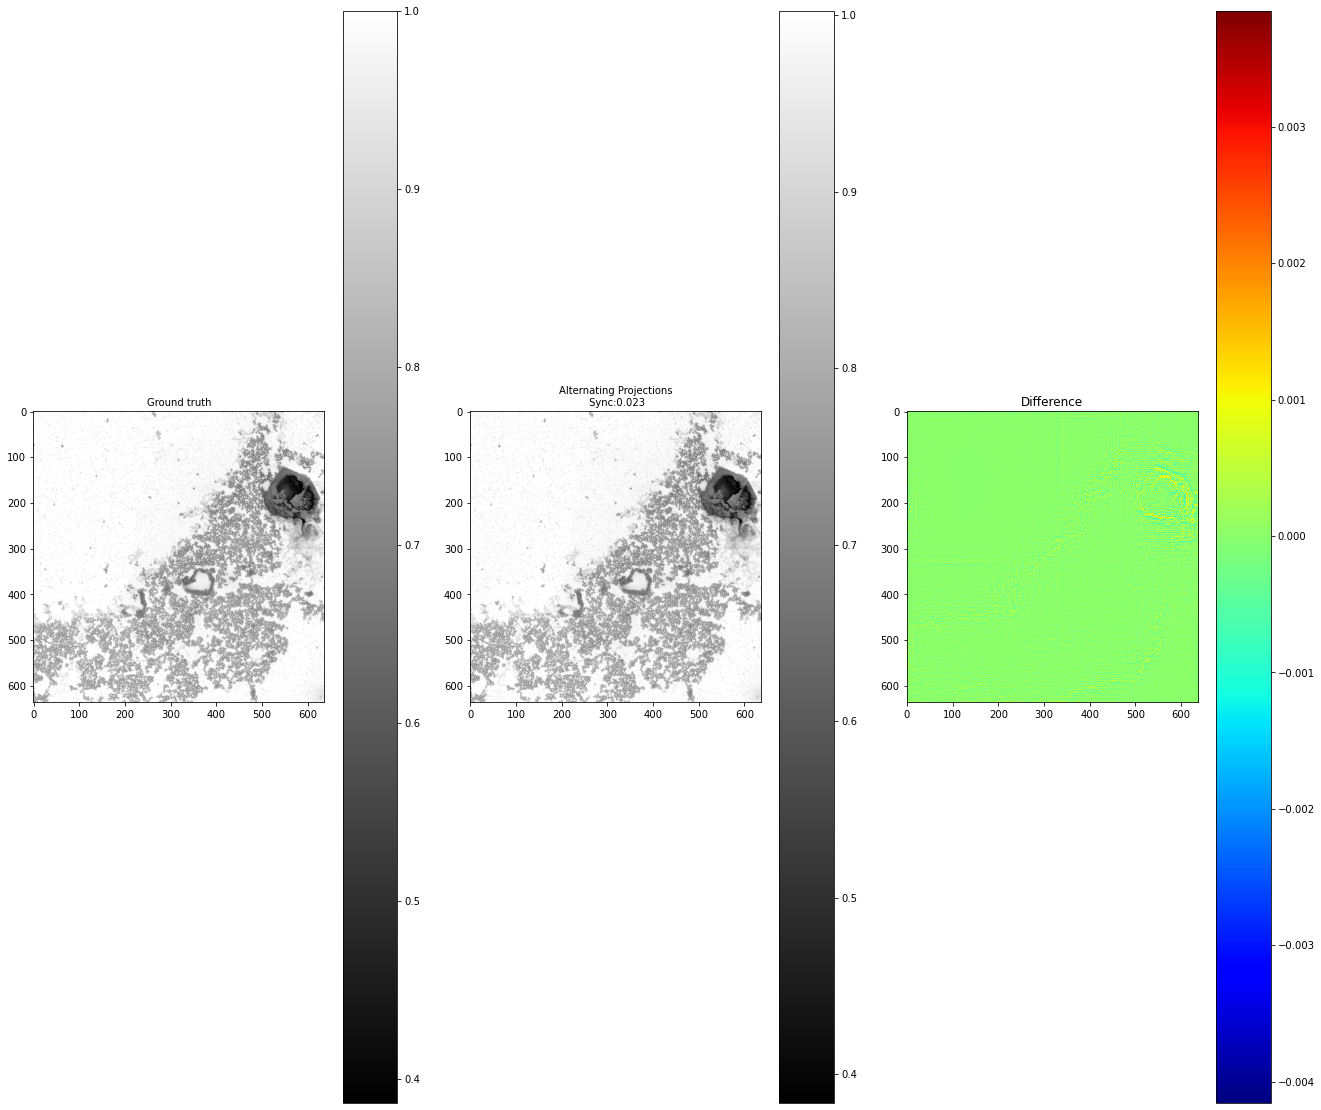

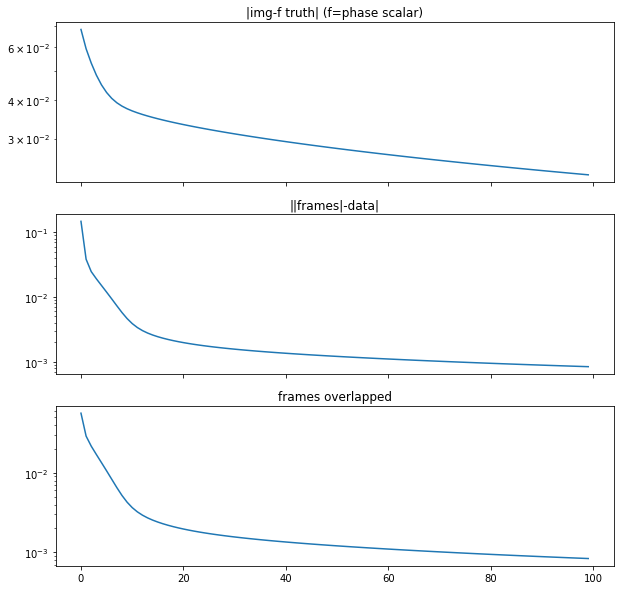

In [12]:
residuals_AP = residuals
img4 = img + 0 
print(type(img),type(img4))
# calculate mse
nrm0 = xp.linalg.norm(truth)
if residuals_AP.size > 0:
    nmse4 = residuals_AP[-1, 0]
else:
    nmse4 = np.NaN

if GPU:
    truth0 = truth.get()
    img = img4.get()
    residuals_AP = residuals_AP.get()
else:
    img = img4

fig = plt.figure(figsize=(30,30))
plt.subplot(1, 4, 1)
plt.title("Ground truth", fontsize=10)
plt.imshow(abs(truth0), cmap="gray")
plt.colorbar()
plt.subplot(1, 4, 2)
plt.title("Alternating Projections\n Sync:%2.2g" % (nmse4), fontsize=10)
plt.imshow(abs(img), cmap="gray")
plt.colorbar()
plt.subplot(1, 4, 3)
plt.title("Difference")
plt.imshow(abs(truth0) - abs(img), cmap="jet")
plt.colorbar()
plt.show()

##

# make a new figure with residuals
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 10))
axs[0].semilogy(residuals_AP[:, 0])
axs[0].set_title("|img-f truth| (f=phase scalar)")
axs[1].semilogy(residuals_AP[:, 1])
axs[1].set_title("||frames|-data|")
axs[2].semilogy(residuals_AP[:, 2])
axs[2].set_title("frames overlapped")
plt.show()


In [22]:
print(residuals)

[[7.81473219e-02 1.74624577e-01 4.25055362e-02 1.27963438e+01]
 [6.44836724e-02 4.90865223e-02 3.13906930e-02 1.55078020e+01]
 [5.89762181e-02 2.98923999e-02 2.41189972e-02 1.69559879e+01]
 [5.53233549e-02 2.37426851e-02 2.02986859e-02 1.80755482e+01]
 [5.26501872e-02 2.06015967e-02 1.82019491e-02 1.89932842e+01]
 [5.07064760e-02 1.88143253e-02 1.69952381e-02 1.97213459e+01]
 [4.92437407e-02 1.77110080e-02 1.62484124e-02 2.03071499e+01]
 [4.81781811e-02 1.70119517e-02 1.59690119e-02 2.07562847e+01]
 [4.75169457e-02 1.66677758e-02 1.62656736e-02 2.10451241e+01]
 [4.71879244e-02 1.68609601e-02 1.68972574e-02 2.11918621e+01]
 [4.70337830e-02 1.74492616e-02 1.74514987e-02 2.12613125e+01]
 [4.68572564e-02 1.81007348e-02 1.78865809e-02 2.13414116e+01]
 [4.64700907e-02 1.84684489e-02 1.75080206e-02 2.15192184e+01]
 [4.61540110e-02 1.81017686e-02 1.70955490e-02 2.16665897e+01]
 [4.58763577e-02 1.76922716e-02 1.67800821e-02 2.17977200e+01]
 [4.58122864e-02 1.74447801e-02 1.72010139e-02 2.182820

In [61]:
print(xp.linalg.norm(abs(img) - abs(truth.get()))/xp.linalg.norm(truth))

0.8554403


In [50]:
print(abs(truth))

[[0.98503375 1.         0.98503375 ... 0.7396432  0.79756624 0.71766955]
 [1.         0.98503375 0.98503375 ... 0.7396432  0.8344751  0.91349614]
 [1.         0.98503375 0.98503375 ... 0.79756624 0.8998245  0.97029155]
 ...
 [0.8344751  0.86002517 0.92737544 ... 0.7622897  0.8863575  0.8863575 ]
 [0.86002517 0.87309206 0.87309206 ... 0.8863575  0.8863575  0.8863575 ]
 [0.7856296  0.92737544 0.92737544 ... 0.8344751  0.7396432  0.7622897 ]]


using GPU
loaded data, memory used, and total: 1281024 1282560
normalized by data.nbytes memory used and total normalized: 1.2216796875 1.22314453125
data size 1048576
----
Split and Overlap, memory used, and total: 1281024 1282560
normalized by data.nbytes memory used and total normalized: 1.2216796875 1.22314453125
data size 1048576
----
geometry: img size: (157, 157) frames: (16, 16, 1024)
not refining illumination, starting with good one, maxiter: 300
start AP memory used, and total: 4340224 36934144
normalized by data.nbytes memory used and total normalized: 4.13916015625 35.22314453125
data size 1048576
----
after Prox_data, memory used, and total: 4349440 36934144
normalized by data.nbytes memory used and total normalized: 4.14794921875 35.22314453125
----
after frames initial, memory used, and total: 6446592 36934144
normalized by data.nbytes memory used and total normalized: 6.14794921875 35.22314453125
----
start loop, memory used, and total: 6649856 36934144
normalized by da

 25%|██▌       | 75/300 [00:00<00:01, 180.65it/s]

nmse0 reach 1e-4 accuracy in 0 iterations and 0.465285113081336 time


100%|██████████| 300/300 [00:00<00:00, 353.48it/s]


end of loop, memory used, and total/1e9: 0.008756224 0.036934144
normalized by data.nbytes memory used and total normalized: 8.3505859375 35.22314453125
----
total time: 0.8722910471260548
{'Overlap': 0, 'Split': 0, 'Prox_data': 0.014847190584987402, 'Data_prox_tot': 0.5407162168994546, 'Propagate': 0.4667370575480163, 'mse_data': 0.058544357772916555, 'Gramiam': 0, 'Gramiam_completion': 0, 'Precondition': 0, 'Eigensolver': 0, 'Sync_setup': 0, 'fd': 0}
total time operators benchmarked: 1.0808448228053749
after normalization


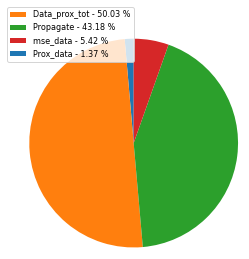

solver timers:
 {'solver_tot': 0.8719194862060249, 'solver_loop': 0.852939123287797, 'ProxD': 0.5526234419085085, 'Overlap': 0.034769933205097914, 'Sync': 0, 'illuminate&split': 0.019474710803478956, 'refine_illumination': 9.938608855009079e-05, 'mse_step': 0.05484469793736935, 'mse_truth': 0.16261422680690885, 'copies': 0.020205837208777666, 'loop_intrnl': 0.8458428108133376, 'solver_final': 0.00505087012425065, 'solver_init': 0.013925943989306688}
solver timers after normalization by 0.852939123287797 :
 {'solver_tot': 1.0222528928501544, 'solver_loop': 1.0, 'ProxD': 0.6479049053094537, 'Overlap': 0.04076484740326059, 'Sync': 0.0, 'illuminate&split': 0.02283247452457148, 'refine_illumination': 0.00011652190154789762, 'mse_step': 0.06430083512403706, 'mse_truth': 0.1906516213960089, 'copies': 0.023689659270043652, 'loop_intrnl': 0.9916801653474336, 'solver_final': 0.005921724055500261, 'solver_init': 0.016327008117093752}
mse timings: 0.3134968142929625
ops timings: 0.7353084084088772

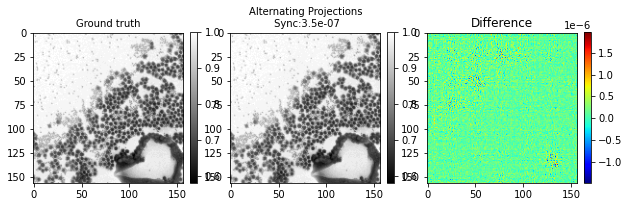

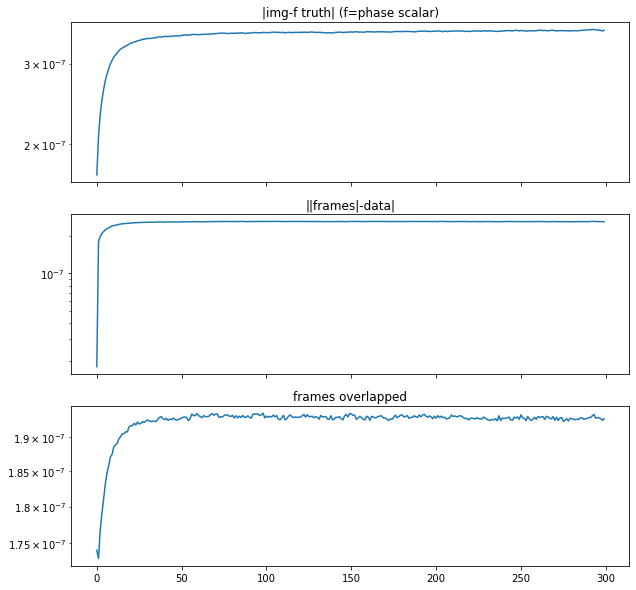

solver tot (seconds) : 0.8719194862060249 loop: 0.852939123287797 seconds
proxD : 64.79049053094536 %
Overlap : 4.076484740326059 %
illuminate and split : 2.283247452457148 %
mse: 32.35908343063146 %
proxD (propagate(ffts), mse, prox)%: (86.31830208909851, 10.827187338419108, 2.7458378574482842)


In [1]:
fname_in = 'poster_32x32.h5'
%run -i ptycho_reconstruct.py

In [7]:
import numpy as np
test1 = [None] * (NTx * NTy) 
for i in range(3):
               a = np.random.randn(2,2)
               print(a)
               test1[i] = a

[[-0.5110559  -0.99286592]
 [-1.16281567  0.12599993]]
[[-0.34630827  0.13303483]
 [-0.05629525  0.84805363]]
[[0.40092422 2.19810278]
 [1.84496501 1.44820709]]
